In [10]:
dataset = "cifar10"
algorithm = "TRADES"

### 1. Load Dataset

In [2]:
from art.utils import load_cifar10
import numpy as np

(_x1, _y1), (_x2, _y2), _min, _max = load_cifar10()
x = np.concatenate((_x1, _x2))
y = np.concatenate((_y1, _y2))

# Swap axes to PyTorch's NCHW format
x = np.transpose(x, (0, 3, 1, 2)).astype(np.float32)

target_train_size = 2500
target_test_size = 2500
x_target_train = x[:target_train_size]
y_target_train = y[:target_train_size]
x_target_test = x[target_train_size:target_train_size+target_test_size]
y_target_test = y[target_train_size:target_train_size+target_test_size]

### 2. Define Target Model

In [3]:
from torch import nn
from torchsummary import summary
import math

def cifar_model(): 
    model = nn.Sequential(
        nn.Conv2d(3, 16, 4, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(16, 32, 4, stride=2, padding=1),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(32*8*8,100),
        nn.ReLU(),
        nn.Linear(100, 10)
    )
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            m.weight.data.normal_(0, math.sqrt(2. / n))
            m.bias.data.zero_()
    return model

summary(cifar_model(), input_size=x_target_train[0].shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             784
              ReLU-2           [-1, 16, 16, 16]               0
            Conv2d-3             [-1, 32, 8, 8]           8,224
              ReLU-4             [-1, 32, 8, 8]               0
           Flatten-5                 [-1, 2048]               0
            Linear-6                  [-1, 100]         204,900
              ReLU-7                  [-1, 100]               0
            Linear-8                   [-1, 10]           1,010
Total params: 214,918
Trainable params: 214,918
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.11
Params size (MB): 0.82
Estimated Total Size (MB): 0.94
----------------------------------------------------------------


### 3. Train Target Model

In [4]:
"""
https://raw.githubusercontent.com/yaodongyu/TRADES/master/trades.py
ICML'19 paper "Theoretically Principled Trade-off between Robustness and Accuracy"
"""
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.nn.modules.loss import _Loss

def trades_loss(model,
                loss_fn,
                x_natural,
                y,
                optimizer,
                norm=2,
                step_size=0.01,
                epsilon=0.25,
                perturb_steps=40,
                beta=6.0,
                version=None,
                device="cpu"):
    # define KL-loss
    criterion_kl = nn.KLDivLoss(size_average=False)
#     criterion_kl = nn.KLDivLoss(reduction='sum')
    model.eval()
    batch_size = len(x_natural)
    # generate adversarial example
    if norm == np.inf:
        x_adv = x_natural.detach() + 0.001 * torch.randn(x_natural.shape).to(device).detach()
        for _ in range(perturb_steps):
            x_adv.requires_grad_()
            with torch.enable_grad():
                loss_kl = criterion_kl(F.log_softmax(model(x_adv), dim=1),
                                       F.softmax(model(x_natural), dim=1))
            grad = torch.autograd.grad(loss_kl, [x_adv])[0]
            x_adv = x_adv.detach() + step_size * torch.sign(grad.detach())
            x_adv = torch.min(torch.max(x_adv, x_natural - epsilon), x_natural + epsilon)
            x_adv = torch.clamp(x_adv, 0.0, 1.0)
    elif norm == 2:
        delta = 0.001 * torch.randn(x_natural.shape).to(device).detach()
        delta = Variable(delta.data, requires_grad=True)

        # Setup optimizers
        optimizer_delta = optim.SGD([delta], lr=epsilon / perturb_steps * 2)

        for _ in range(perturb_steps):
            adv = x_natural + delta

            # optimize
            optimizer_delta.zero_grad()
            with torch.enable_grad():
                loss = (-1) * criterion_kl(F.log_softmax(model(adv), dim=1),
                                           F.softmax(model(x_natural), dim=1))
            loss.backward()
            # renorming gradient
            grad_norms = delta.grad.view(batch_size, -1).norm(p=2, dim=1)
            delta.grad.div_(grad_norms.view(-1, 1, 1, 1))
            # avoid nan or inf if gradient is 0
            if (grad_norms == 0).any():
                delta.grad[grad_norms == 0] = torch.randn_like(delta.grad[grad_norms == 0])
            optimizer_delta.step()

            # projection
            delta.data.add_(x_natural)
            delta.data.clamp_(0, 1).sub_(x_natural)
            delta.data.renorm_(p=2, dim=0, maxnorm=epsilon)
        x_adv = Variable(x_natural + delta, requires_grad=False)
    else:
        x_adv = torch.clamp(x_adv, 0.0, 1.0)
    model.train()

    x_adv = Variable(torch.clamp(x_adv, 0.0, 1.0), requires_grad=False)
    # zero gradient
    optimizer.zero_grad()
    # calculate robust loss
    outputs = model(x_natural)
    loss_natural = loss_fn(outputs, y)
    loss_robust = (1.0 / batch_size) * criterion_kl(F.log_softmax(model(x_adv), dim=1),
                                                    F.softmax(model(x_natural), dim=1))
    if version is not None and "sum" in version:
        loss = loss_natural + beta * batch_size * loss_robust
    else:
        loss = loss_natural + beta * loss_robust
    return outputs, loss

In [5]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from tqdm import tqdm

class PytorchDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x)
        self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

def train(dataloader, model, loss_fn, optimizer):
    for batch, (i_batch, o_batch) in enumerate(dataloader):
        optimizer.zero_grad()
        (_, loss) = trades_loss(model, loss_fn, i_batch, o_batch, optimizer=optimizer)
        loss.backward()
        optimizer.step()

def get_acc(model, x, y):
    _, predictions = torch.max(model(torch.from_numpy(x)), 1)
    acc = np.mean(predictions.detach().numpy() == np.argmax(y, axis=1))
    return acc

model = cifar_model()
train_dataloader = DataLoader(PytorchDataset(x_target_train, y_target_train), batch_size=64, shuffle=True)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

nb_epochs = 100
best_acc = 0
for i in tqdm(range(nb_epochs)):
    model.train()
    train(train_dataloader, model, loss_fn, optimizer)
    model.eval()
    test_acc = get_acc(model, x_target_test, y_target_test)
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), f"models/{dataset}_{algorithm}.pth")

# load best model
# model.load_state_dict(torch.load(f"models/{dataset}_{algorithm}.pth"))
model.eval()
print("Train accuracy:", get_acc(model, x_target_train, y_target_train))
print("Test accuracy:", get_acc(model, x_target_test, y_target_test))

  0%|          | 0/100 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniconda/base/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 100/100 [39:02<00:00, 23.43s/it]

Train accuracy: 1.0
Test accuracy: 0.468


### 4. Generate Adversarial Examples using HopSkipJump

In [6]:
from art.attacks.evasion import HopSkipJump
from art.estimators.classification.pytorch import PyTorchClassifier
from numpy.random import choice

art_classifier=PyTorchClassifier(
    model=model,
    clip_values=(_min, _max),
    loss=loss_fn,
    optimizer=optimizer,
    input_shape=(3, 32, 32),
    nb_classes=10,
)
attack = HopSkipJump(classifier=art_classifier, norm=2, targeted=False)

train_idx = choice(len(x_target_train), 100)
y_adv_train = y_target_train[train_idx]
x_adv_train = attack.generate(x=x_target_train[train_idx], y=y_adv_train)

test_idx = choice(len(x_target_test), 100)
y_adv_test = y_target_test[test_idx]
x_adv_test = attack.generate(x=x_target_test[test_idx], y=y_adv_test)

HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

### 5. Measure the Distribution of Distance to Decision Boundary

                0
count  100.000000
mean     1.230336
std      0.588519
min      0.643085
25%      0.883783
50%      1.035861
75%      1.254032
max      3.906929
                0
count  100.000000
mean     0.371654
std      0.412887
min      0.000365
25%      0.087244
50%      0.210245
75%      0.546276
max      2.560135


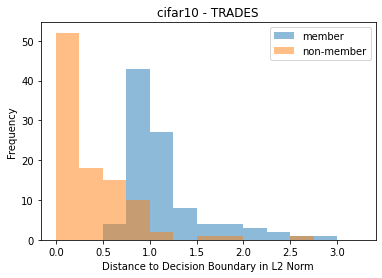

In [13]:
from matplotlib import pyplot as plt
import pandas as pd

def dist(x, x_adv):
    return np.linalg.norm(np.reshape(x_adv - x, [-1]))

dist_train = [dist(x, xa) for (x, xa) in zip(x_target_train[train_idx], x_adv_train)]
dist_test = [dist(x, xa) for (x, xa) in zip(x_target_test[test_idx], x_adv_test)]
print(pd.DataFrame(np.array(dist_train)).describe())
print(pd.DataFrame(np.array(dist_test)).describe())

bins = [0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25]

plt.hist(dist_train, bins, alpha=0.5, label='member')
plt.hist(dist_test, bins, alpha=0.5, label='non-member')
plt.legend(loc='upper right')
plt.title(f'{dataset} - {algorithm}')
plt.xlabel("Distance to Decision Boundary in L2 Norm")
plt.ylabel("Frequency")
plt.show()

### 6. Measure the Advantage of An Adversary in Label-Only Membership Inference Attacks

[0.   0.   0.   0.01 0.01 0.02 0.02 0.03 0.03 0.04 0.04 0.05 0.05 0.07
 0.07 0.08 0.08 0.09 0.09 0.1  0.1  0.11 0.11 0.12 0.12 0.13 0.13 0.14
 0.14 0.15 0.15 0.18 0.18 1.  ]
[0.   0.01 0.04 0.04 0.12 0.12 0.18 0.18 0.39 0.39 0.51 0.51 0.58 0.58
 0.59 0.59 0.7  0.7  0.73 0.73 0.76 0.76 0.79 0.79 0.87 0.87 0.9  0.9
 0.94 0.94 0.99 0.99 1.   1.  ]
[4.9069295e+00 3.9069295e+00 2.9697809e+00 2.5601346e+00 1.9454507e+00
 1.8588061e+00 1.5767176e+00 1.5072656e+00 1.1234378e+00 1.1218526e+00
 1.0344099e+00 1.0313294e+00 9.8582095e-01 9.8433167e-01 9.8292476e-01
 9.7636032e-01 9.1753221e-01 9.1443688e-01 9.0660709e-01 8.9870852e-01
 8.7771404e-01 8.7712133e-01 8.7292236e-01 8.7090886e-01 8.3259934e-01
 8.2497346e-01 8.1829751e-01 8.1148142e-01 7.9182762e-01 7.8223324e-01
 6.8218356e-01 6.4413989e-01 6.4308494e-01 3.6462006e-04]


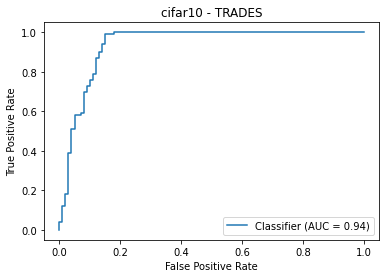

In [14]:
from matplotlib import pyplot as plt
from sklearn.metrics import RocCurveDisplay, roc_curve

fpr, tpr, thresholds = roc_curve(
    np.concatenate((np.ones(len(dist_train)), np.zeros(len(dist_test)))),
    dist_train + dist_test
)
print(fpr)
print(tpr)
print(thresholds)

RocCurveDisplay.from_predictions(
    np.concatenate((np.ones(len(dist_train)), np.zeros(len(dist_test)))),
    dist_train + dist_test
)
plt.title(f'{dataset} - {algorithm}')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

### 7. Measure the Statistical Relationship between Distance to Decision Boundary and Confidence Scores

In [9]:
from scipy.stats.stats import pearsonr
import scipy

confidence_train = [np.amax(scipy.special.softmax(p)) for p in art_classifier.predict(x_target_train[train_idx])]
confidence_test = [np.amax(scipy.special.softmax(p)) for p in art_classifier.predict(x_target_test[test_idx])]

corr, pvalue = pearsonr(confidence_train, dist_train)
print("train correlation ", corr, pvalue)
corr, pvalue = pearsonr(confidence_test, dist_test)
print("test correlation ", corr, pvalue)

train correlation  0.22913925349781625 0.021837357520933406
test correlation  0.6527378098873591 1.8579028802832494e-13
